## Data Understanding

1. Import Libraries

In [263]:
import pandas as pd
import nltk
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

#pd.set_option('display.max_colwidth', None)
# use to view full tweet context

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ndegwa/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ndegwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ndegwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ndegwa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ndegwa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [264]:
tweets = pd.read_csv('judge_tweet_product_company.csv',encoding='ISO-8859-1')
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [265]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [266]:
tweets.shape

(9093, 3)

In [267]:
tweets.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [268]:
tweets.duplicated().sum()

22

## Data Cleaning

In [269]:
# Rename the columns
tweets.rename(columns={
    'tweet_text': 'text',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}, inplace=True)

### Emotion column cleaning

In [270]:
# Check unique values
emotions = tweets['emotion'].unique()
print("Emotions:", emotions)

Emotions: ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]


In [271]:
# Print value counts for the 'emotion' column
print(tweets['emotion'].value_counts())

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64


To clean the emotion column for easier handling, we can simplify these categories to make analysis more straightforward. 

Drop I can't tell rows

Combine Ambiguous Emotions: Group the categories for ambiguous or neutral responses, such as "No emotion toward brand or product" and "I can't tell," into a single category, "Neutral".

Label Encoding: Assign numerical values to each category for better compatibility with machine learning models (e.g., -1 for "Negative," 0 for "Neutral," and 1 for "Positive").

Map to Simple Labels: Shorten each category name for easier interpretation, like:

"Positive" for "Positive emotion"
"Negative" for "Negative emotion"
"Neutral" for "No emotion toward brand or product"


In [272]:
# Find rows with 'I cant tell'
uncertain_rows = tweets[tweets['emotion'] == "I can't tell"].index

# Remove the identified records
tweets.drop(index=uncertain_rows, inplace=True)

# Define a mapping dictionary to simplify the emotion categories
emotion_mapping = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral',
}

# Apply the mapping to the emotion column
tweets['emotion'] = tweets['emotion'].map(emotion_mapping)

# Check the value counts to confirm changes
print(tweets['emotion'].value_counts())


Neutral     5389
Positive    2978
Negative     570
Name: emotion, dtype: int64


In [273]:
tweets['emotion'].value_counts().sum()

8937

### Product Column cleaning

In [274]:
# Find the records with missing values in the column
tweets[tweets['product'].isnull() == True].shape[0]

5655

In [275]:
print(tweets['product'].value_counts())

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64


So we will try check the text column with reference to the unique vaues in the product column, and fill the product column missing values with the product names described from the unique list. 
we want to have a larger dataset for more significant sentiment analysis

In [276]:
# List of unique products/services,
products = list(tweets['product'].unique())
products.remove(np.nan)

# Define a regex pattern for any product
pattern = re.compile(r'\b(' + '|'.join(re.escape(str(p)) for p in products) + r')\b', re.IGNORECASE)

# c
def find_product_with_regex(tweet):
    # Check if the tweet is a string before performing regex search
    if isinstance(tweet, str):
        match = pattern.search(tweet)
        if match:
            return match.group(0)
    return np.nan  # Return NaN if no product is found

# Apply the function to fill missing values in 'product' column
tweets['product'] = tweets['product'].fillna(tweets['text'].apply(find_product_with_regex))
tweets['product'].fillna('unknown', inplace=True)

In [277]:
# Check for any remaining null values in the 'product' column
tweets[tweets['product'].isnull() == True].shape[0]

0

In the tweets dataset, some rows have missing values in the product column, which we previously attempted to populate with the names of products mentioned in each tweet. These missing values are likely from tweets that don’t mention any specific product or where we couldn't detect a product name due to variations in spelling or phrasing.

To handle these missing entries, we chose to impute them with the label 'unknown'. This approach allows us to retain these rows in the dataset rather than dropping them, which would reduce our sample size and potentially lead to a loss of valuable contextual information.

In [278]:
# lets drop the NaN values from the product column
tweets['product'] = tweets['product'].dropna()

In [279]:
# Check unique values
unique_products = tweets['product'].unique()
print("Unique products:", unique_products)

Unique products: ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' 'unknown' 'Android' 'Apple'
 'Android App' 'Other Google product or service' 'ipad' 'google' 'APPLE'
 'apple' 'android' 'iphone' 'IPad' 'Other Apple product or service'
 'IPhone' 'GOOGLE' 'Ipad' 'Iphone' 'IPAD' 'iPAD' 'iPHONE' 'ANDROID']


In [280]:
# Number of values in the column are the same as the length of the data
np.sum(tweets['product'].value_counts().values) == tweets.shape[0]

True

With the various products it would be benefitial to categorize them to three groups, this wold allow classify new products to the category and be aware of the brand comparison in terms of the products each offer

 - We start by defining two lists, apple_products and google_products, each containing names of well-known products associated with Apple and Google, respectively
 - These lists allow the program to check for matches against a known set of brand products
 - We convert all values in the product column to lowercase
- Define a function to to check the product and compares with the apple products or google products list.
- Match the apppriate product to each category if "unknown" is encoutered it should go to the other category.

In [281]:
# Number of values in the column are the same as the length of the data
np.sum(tweets['product'].value_counts().values) == tweets.shape[0]

True

In [282]:
tweets.head()

,text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


### Text Column cleaning

In [283]:
# lets drop the null value in text column
tweets.dropna(subset=['text'], inplace=True)

In [284]:
 # Remove non-ASCII characters in the text column
tweets['text'] = tweets['text'].apply(lambda x: ''.join([char for char in str(x) if ord(char) < 127]))

In [285]:
tweets.head()

,text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [286]:
# Reset the index
tweets.reset_index(inplace=True)
# Drop the old index column
tweets.drop(labels='index', axis=1, inplace=True)
tweets.head()

,text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


## Univariate Analysis


Univariate analysis examines individual columns to understand their distributions and characteristics.

+ Distribution of emotion: This shows how positive and negative emotions are distributed across the dataset.
+ Distribution of product: This helps understand the frequency of the products mentioned.
+ Text Analysis: We can analyze the frequency of words in the text column to identify common terms.

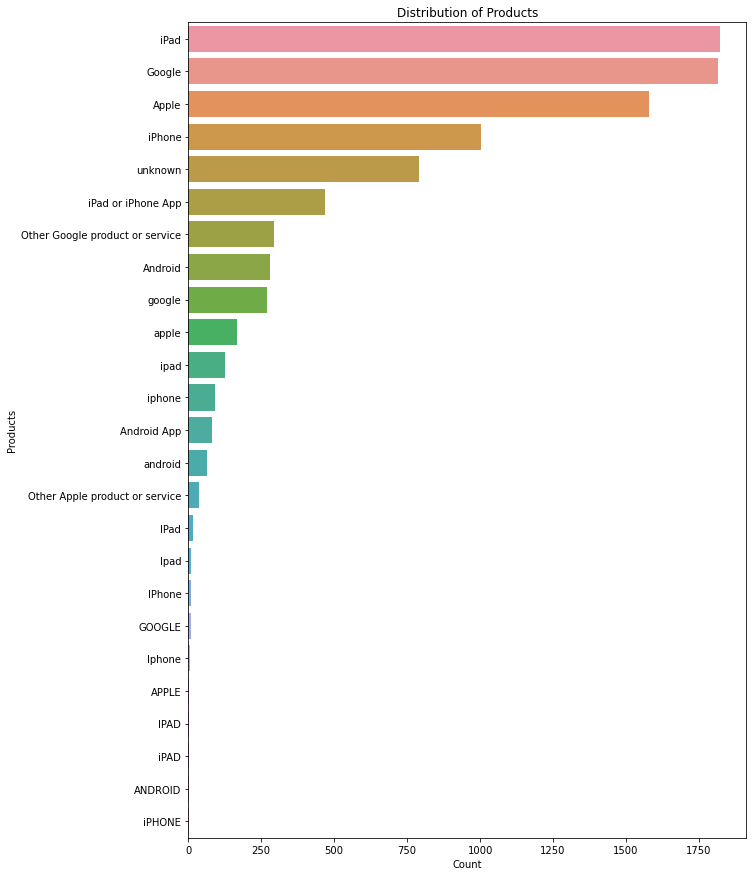

In [287]:
plt.figure(figsize=(10, 15))
sns.countplot(y='product', data=tweets, order=tweets['product'].value_counts().index)
plt.title('Distribution of Products')
plt.xlabel('Count')
plt.ylabel('Products')
plt.show()

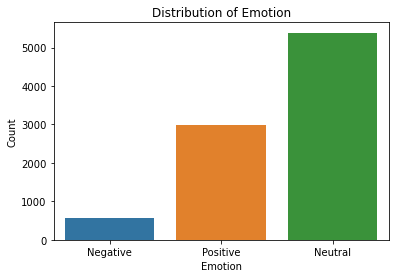

In [288]:
# Countplot for emotion
plt.figure(figsize=(6, 4))
sns.countplot(x='emotion', data=tweets)
plt.title('Distribution of Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


For the Text column we have to clean the text to get a view of ost mentioned words that offer insights on emotion towards a product ar brand

+ Text Cleaning and Processing:

 + Remove URLs: Detects and removes any URLs in the text. 
 + Remove Mentions: Removes any mentions of users.
 + Remove Hashtags (Keep Text): Removes the # symbol from hashtags but keeps the rest of the hashtag text.
 + Remove Special Characters: Eliminates HTML-like special characters.
 + Remove Punctuation: Removes any punctuation marks from the text.
 + Tokenization: Splits the text into lowercase words (tokens), breaking at any non-word characters.
 + Stopword Removal and Lemmatization: Removes common stopwords and lemmatizes each token to reduce words to their base forms.
 + Remove Extra Whitespace: Strips any extra spaces left around each word, removing empty tokens.
 + Remove Numbers: Filters out any numeric tokens.
 + Part-of-Speech (POS) Tagging and Filtering: Tags each token with its part of speech and filters to retain only nouns, adjectives, verbs, and adverbs.
 + Join Tokens into String: Joins the cleaned tokens back into a single string for easier use in text analysis.

In [289]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english') + ['sxsw', 'sxswi', 'link', 'rt'])

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (keep the text after the #)
    text = re.sub(r'#', '', text)
    # Remove special characters like "&quot;"
    text = re.sub(r'&\w+;', '', text)
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize text
    tokens = re.split('\W+', text.lower())
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Remove extra white spaces
    tokens = [word.strip() for word in tokens if word.strip() != '']
    # Remove numbers
    tokens = [word for word in tokens if not word.isdigit()]
    # Tag parts of speech
    pos_tags = nltk.pos_tag(tokens)
    # Filter tokens to retain only nouns, adjectives, verbs, and adverbs
    important_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}
    tokens = [word for word, tag in pos_tags if tag in important_pos]
    return tokens



In [318]:
# Apply the cleaning function to the 'text' column
tweets['cleaned_text'] = tweets['text'].apply(lambda x: clean_text(x))

# Cleaned text might already be a string, so no need for " ".join if it's not a list
# tweets['clean_tweet'] = tweets['cleaned_text'].apply(lambda x: x.strip() if isinstance(x, str) else " ".join(x).strip())


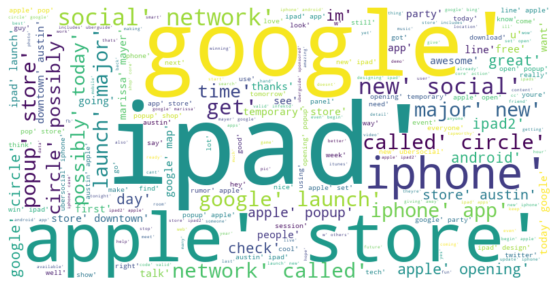

In [319]:
# Combine all the cleaned text into a single string for the word cloud
all_cleaned_text = " ".join(tweets['cleaned_text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_text)

# Display the word cloud
plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()


my code keeps having showing these (') in the wordcloud, an error still to disolve.

## Bivariate Analysis

Lets make a catgorized column with the 3 values for apple, google and unknown products to visualize the effects of the product on the other features

In [292]:
def categorize_product(product):
    if not isinstance(product, str):
        return 'other'  # Assign 'other' to non-string or missing values
    
    # List of keywords for classification
    apple_keywords = ['iphone', 'ipad', 'mac', 'ios', 'apple', 'ipad or iphone app', 'apple product', 'other apple product']
    google_keywords = ['google', 'android', 'google product', 'android app', 'other google product']

    # Lowercase the product for consistent matching
    product = product.lower()
    
    # Initialize category as 'other'
    category = 'other'
    
    # Check for Apple-related keywords
    for keyword in apple_keywords:
        if keyword in product:
            category = 'apple'
            break

    # Check for Google-related keywords
    for keyword in google_keywords:
        if keyword in product:
            category = 'google'
            break

    return category

# Apply the new categorization function
tweets['product_category'] = tweets['product'].apply(categorize_product)

# Print value counts for the 'product_category' column
print(tweets['product_category'].value_counts())


apple     5338
google    2809
other      789
Name: product_category, dtype: int64


In [293]:
# Check which products are categorized as 'other'
other_category_products = tweets[tweets['product_category'] == 'other']['product']
print(other_category_products.unique())

['unknown']


In [294]:
# Drop rows where 'product_category' is 'other'
# tweets = tweets[tweets['product_category'] != 'other']

# check the unique values in 'product_category'
print(tweets['product_category'].value_counts())


apple     5338
google    2809
other      789
Name: product_category, dtype: int64


### Product Category vs. Emotion

This analysis shows if certain product categories are associated with more positive or negative emotions.

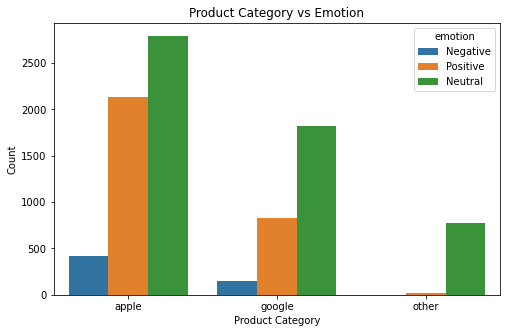

In [295]:
# Countplot for product category vs emotion
plt.figure(figsize=(8, 5))
sns.countplot(x='product_category', hue='emotion', data=tweets)
plt.title('Product Category vs Emotion')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()


### Product Category vs. Product
This analysis will help see which specific products fall under each category.

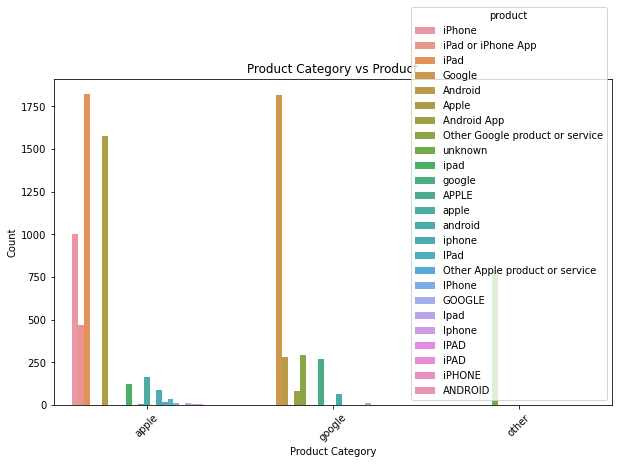

In [296]:
# Countplot for product category vs product
plt.figure(figsize=(10, 6))
sns.countplot(x='product_category', hue='product', data=tweets)
plt.title('Product Category vs Product')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## Feature Engineering


In [297]:
# For this feature lets create a copy of the dataset and include the features identified
tweets_engineered = tweets.copy()

In [298]:
tweets_engineered.head()

,text,product,emotion,cleaned_text,clean_tweet,product_category
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,"[iphone, hr, tweeting, riseaustin, dead, need,...",iphone hr tweeting riseaustin dead need upgrad...,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,"[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,"[wait, ipad, also, sale]",wait ipad also sale,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,"[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,"[great, stuff, fri, mayer, google, tim, oreill...",great stuff fri mayer google tim oreilly tech ...,google


In [299]:
tweets_engineered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text              8936 non-null   object
 1   product           8936 non-null   object
 2   emotion           8936 non-null   object
 3   cleaned_text      8936 non-null   object
 4   clean_tweet       8936 non-null   object
 5   product_category  8936 non-null   object
dtypes: object(6)
memory usage: 419.0+ KB


## Data Preprocessing

**The following process were identified as steps taken for preprocessing the dataset**

+ Label Encoding:
    The emotion column has been encoded for compatibility with machine learning models, using the following labels:

    Positive: 1
    Neutral: 0
    Negative: -1
    The product_category column has been encoded with the following labels:

    Apple: 1
    Google: 2
    Other: 3

+ Product Normalization: We convert all product names to lowercase to ensure consistency. If necessary, we could also merge entries that are essentially the same (like "iphone" and "i-phone") by mapping them to a single identifier.



In [300]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text              8936 non-null   object
 1   product           8936 non-null   object
 2   emotion           8936 non-null   object
 3   cleaned_text      8936 non-null   object
 4   clean_tweet       8936 non-null   object
 5   product_category  8936 non-null   object
dtypes: object(6)
memory usage: 419.0+ KB


In [301]:
tweets['emotion'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: emotion, dtype: int64

In [302]:
tweets['product'].value_counts()

iPad                               1821
Google                             1816
Apple                              1577
iPhone                             1004
unknown                             789
iPad or iPhone App                  470
Other Google product or service     292
Android                             279
google                              269
apple                               166
ipad                                125
iphone                               90
Android App                          81
android                              63
Other Apple product or service       35
IPad                                 17
Ipad                                 10
IPhone                                8
GOOGLE                                8
Iphone                                5
APPLE                                 4
IPAD                                  3
iPAD                                  2
ANDROID                               1
iPHONE                                1


In [303]:
# Define custom mappings for the 'emotion' and 'product_category' columns
emotion_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1,
}

product_category_mapping = {
    'apple': 1,
    'google': 2,
    'other': 3
}

# Apply mappings to create new encoded columns
tweets['product_category_encoded'] = tweets['product_category'].map(product_category_mapping)
tweets['emotion_encoded'] = tweets['emotion'].map(emotion_mapping)


# Normalize product names to lowercase and remove duplicates
tweets['product'] = tweets['product'].str.lower()


In [304]:

# Check Label encoded columns
print(tweets['product_category_encoded'].value_counts())

1    5338
2    2809
3     789
Name: product_category_encoded, dtype: int64


In [305]:
print(tweets['emotion_encoded'].value_counts())

 0    5388
 1    2978
-1     570
Name: emotion_encoded, dtype: int64


In [306]:
# Check unique values and counts after standardization
print(tweets['product'].value_counts())

google                             2093
ipad                               1978
apple                              1747
iphone                             1108
unknown                             789
ipad or iphone app                  470
android                             343
other google product or service     292
android app                          81
other apple product or service       35
Name: product, dtype: int64


In [307]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   text                      8936 non-null   object
 1   product                   8936 non-null   object
 2   emotion                   8936 non-null   object
 3   cleaned_text              8936 non-null   object
 4   clean_tweet               8936 non-null   object
 5   product_category          8936 non-null   object
 6   product_category_encoded  8936 non-null   int64 
 7   emotion_encoded           8936 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 558.6+ KB


In [308]:
tweets.head()

,text,product,emotion,cleaned_text,clean_tweet,product_category,product_category_encoded,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iphone,Negative,"[iphone, hr, tweeting, riseaustin, dead, need,...",iphone hr tweeting riseaustin dead need upgrad...,apple,1,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,ipad or iphone app,Positive,"[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...,apple,1,1
2,@swonderlin Can not wait for #iPad 2 also. The...,ipad,Positive,"[wait, ipad, also, sale]",wait ipad also sale,apple,1,1
3,@sxsw I hope this year's festival isn't as cra...,ipad or iphone app,Negative,"[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app,apple,1,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,google,Positive,"[great, stuff, fri, mayer, google, tim, oreill...",great stuff fri mayer google tim oreilly tech ...,google,2,1


In [309]:
# Drop original columns and keep the cleaned version
tweets_cleaned = tweets.drop(['text', 'product_category', 'emotion','product','cleaned_text'], axis=1)

# Display the processed dataset first few rows
tweets_cleaned.head()

,clean_tweet,product_category_encoded,emotion_encoded
0,iphone hr tweeting riseaustin dead need upgrad...,1,-1
1,know awesome ipadiphone app youll likely appre...,1,1
2,wait ipad also sale,1,1
3,hope year festival isnt crashy year iphone app,1,-1
4,great stuff fri mayer google tim oreilly tech ...,2,1


## Data Modelling


In [310]:
tweets_cleaned.head()

,clean_tweet,product_category_encoded,emotion_encoded
0,iphone hr tweeting riseaustin dead need upgrad...,1,-1
1,know awesome ipadiphone app youll likely appre...,1,1
2,wait ipad also sale,1,1
3,hope year festival isnt crashy year iphone app,1,-1
4,great stuff fri mayer google tim oreilly tech ...,2,1


In [311]:
tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   clean_tweet               8936 non-null   object
 1   product_category_encoded  8936 non-null   int64 
 2   emotion_encoded           8936 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 209.6+ KB


In [312]:

# Ensure `clean_tweet` is a string by joining tokens
tweets_cleaned['clean_tweet'] = tweets_cleaned['clean_tweet'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [313]:
tweets_cleaned

,clean_tweet,product_category_encoded,emotion_encoded
0,iphone hr tweeting riseaustin dead need upgrad...,1,-1
1,know awesome ipadiphone app youll likely appre...,1,1
2,wait ipad also sale,1,1
3,hope year festival isnt crashy year iphone app,1,-1
4,great stuff fri mayer google tim oreilly tech ...,2,1
...,...,...,...
8931,ipad everywhere,1,1
8932,wave buzz interrupt regularly scheduled geek p...,2,0
8933,google zeiger physician never reported potenti...,2,0
8934,verizon iphone customer complained time fell b...,1,0


In [314]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

# Initialize vectorizers and SMOTE
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
smote = SMOTE(random_state=42)

# Create pipelines
count_pipeline = ImbPipeline([
    ('vectorizer', count_vectorizer),
    ('smote', smote),
    ('classifier', LogisticRegression(max_iter=1000))  # Placeholder classifier
])

tfidf_pipeline = ImbPipeline([
    ('vectorizer', tfidf_vectorizer),
    ('smote', smote),
    ('classifier', LogisticRegression(max_iter=1000))  # Placeholder classifier
])

# Define X and Y
X = tweets_cleaned['clean_tweet']  # Ensure this is the column with cleaned text data
Y = tweets['emotion_encoded']      # Target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Dictionary to store results
results = {}

# Evaluate each model with both vectorizers
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Update the classifier in the pipelines
    count_pipeline.set_params(classifier=model)
    tfidf_pipeline.set_params(classifier=model)

    # Train and evaluate the model with CountVectorizer
    print(f"\nUsing CountVectorizer with {model_name}:")
    count_pipeline.fit(X_train, y_train)
    y_pred_count = count_pipeline.predict(X_test)
    results[f'Count_{model_name}'] = classification_report(y_test, y_pred_count)
    print(results[f'Count_{model_name}'])

    # Train and evaluate the model with TfidfVectorizer
    print(f"\nUsing TfidfVectorizer with {model_name}:")
    tfidf_pipeline.fit(X_train, y_train)
    y_pred_tfidf = tfidf_pipeline.predict(X_test)
    results[f'Tfidf_{model_name}'] = classification_report(y_test, y_pred_tfidf)
    print(results[f'Tfidf_{model_name}'])

# Results for each model and vectorizer combination
for key, report in results.items():
    print(f"\n{key} Classification Report:\n{report}")

Evaluating Logistic Regression...

Using CountVectorizer with Logistic Regression:
              precision    recall  f1-score   support

          -1       0.27      0.45      0.34       114
           0       0.73      0.67      0.70      1078
           1       0.55      0.55      0.55       596

    accuracy                           0.62      1788
   macro avg       0.51      0.56      0.53      1788
weighted avg       0.64      0.62      0.63      1788


Using TfidfVectorizer with Logistic Regression:
              precision    recall  f1-score   support

          -1       0.32      0.54      0.41       114
           0       0.75      0.69      0.72      1078
           1       0.58      0.59      0.58       596

    accuracy                           0.65      1788
   macro avg       0.55      0.61      0.57      1788
weighted avg       0.67      0.65      0.65      1788

Evaluating Random Forest...

Using CountVectorizer with Random Forest:
              precision    recall  

In [315]:
# Logistic Regression Hyperparameters
log_reg_params = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
    'logisticregression__max_iter': [200, 300, 500],
    'logisticregression__class_weight': ['balanced']

}

# Logistic Regression Pipeline
from imblearn.pipeline import Pipeline as im_pipeline
log_reg_pipeline = im_pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('logisticregression', LogisticRegression())
])

log_reg_grid_search = GridSearchCV(log_reg_pipeline, log_reg_params, cv=3, n_jobs=-1, verbose=1)
log_reg_grid_search.fit(X_train, y_train)

# Best Hyperparameters for Logistic Regression
print("Best Parameters for Logistic Regression: ", log_reg_grid_search.best_params_)

# Best Model Evaluation
log_reg_best_model = log_reg_grid_search.best_estimator_
print("Logistic Regression Accuracy: ", log_reg_best_model.score(X_test, y_test))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters for Logistic Regression:  {'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 300, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Logistic Regression Accuracy:  0.6588366890380313


/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [316]:
# Random Forest Hyperparameters
rf_params = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

# Random Forest Pipeline
rf_pipeline = im_pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])

rf_grid_search = GridSearchCV(rf_pipeline, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best Hyperparameters for Random Forest
print("Best Parameters for Random Forest: ", rf_grid_search.best_params_)

# Best Model Evaluation
rf_best_model = rf_grid_search.best_estimator_
print("Random Forest Accuracy: ", rf_best_model.score(X_test, y_test))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters for Random Forest:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Random Forest Accuracy:  0.6812080536912751


In [317]:
# SVM Hyperparameters
svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto'],

    'svc__class_weight': ['balanced']
}

# SVM Pipeline
svm_pipeline = im_pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(random_state=42))
])

svm_grid_search = GridSearchCV(svm_pipeline, svm_params, cv=3, n_jobs=-1, verbose=1)
svm_grid_search.fit(X_train, y_train)

# Best Hyperparameters for SVM
print("Best Parameters for SVM: ", svm_grid_search.best_params_)

# Best Model Evaluation
svm_best_model = svm_grid_search.best_estimator_
print("SVM Accuracy: ", svm_best_model.score(X_test, y_test))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for SVM:  {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
SVM Accuracy:  0.6929530201342282


After evaluating multiple models, the results were as follows:

**SVM (Support Vector Machine):**

+ Best Parameters: C=1, class_weight='balanced', gamma='scale', kernel='rbf'.
+ Accuracy: 69.3%.
+ CountVectorizer: Achieved accuracy of 63%, with decent performance in classifying '0' and '1' but poor performance for the 'negative emotion' class (-1).
+ TfidfVectorizer: Slightly improved to 69%, still showing strength for classifying neutral (0) and positive (1) emotions, but weaker for the negative emotion class.

**Random Forest:**

+ Best Parameters: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1.
+ Accuracy: 68.1%.
+ CountVectorizer: Had a relatively balanced performance but still showed struggles in identifying negative emotions.
+ TfidfVectorizer: Improved performance to 69%, with better recall for the neutral class but still not hitting above 70% for overall accuracy.

**Logistic Regression:**

+ Best Parameters: C=10, class_weight='balanced', max_iter=300, penalty='l2', solver='lbfgs'.
+ Accuracy: 65.9%.
+ CountVectorizer: Accuracy of 62%, with precision and recall still falling short for 'negative emotion'.
+ TfidfVectorizer: Boosted accuracy to 65%, with a better balance in precision and recall for the neutral and positive classes.